# Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Loading date wrangling package
from datetime import datetime, timedelta

# Data Input and Cleaning

In [10]:
# Reading the input data
d = pd.read_csv('project_dataset.csv')
d.rename(columns = {'DAYTON_MW':'MW'}, inplace = True)

# Formating to datetime
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# To make sure there are no duplicate data in the dataset, we group the data by Datetime column and average duplicate values if any
d = d.groupby('Datetime', as_index=False)['MW'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

# Complete Deep Learning model package

In [11]:
class DeepModelTimeSeries():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [12]:
# Creating the model using full data and forecasting n steps ahead
# Note every n step corresponds to 1 hour increment as per our dataset
deep_learner = DeepModelTimeSeries(
data=d,
Y_var='MW',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)
# Fitting the model
deep_learner.LSTModel()

Epoch 1/10
474/474 [==============================] - 47s 97ms/step - loss: 350000096.0000
Epoch 2/10
474/474 [==============================] - 46s 97ms/step - loss: 22609374.0000
Epoch 3/10
474/474 [==============================] - 46s 97ms/step - loss: 2806655.0000
Epoch 4/10
474/474 [==============================] - 46s 97ms/step - loss: 491886.2188
Epoch 5/10
474/474 [==============================] - 46s 97ms/step - loss: 456819.8438
Epoch 6/10
474/474 [==============================] - 46s 97ms/step - loss: 440565.7188
Epoch 7/10
474/474 [==============================] - 46s 97ms/step - loss: 417946.2188
Epoch 8/10
474/474 [==============================] - 46s 97ms/step - loss: 397997.0312
Epoch 9/10
474/474 [==============================] - 46s 97ms/step - loss: 372310.6250
Epoch 10/10
474/474 [==============================] - 46s 97ms/step - loss: 349937.3438


In [13]:
# Forecasting n steps ahead
# Note every n step corresponds to 1 hour increment as per our dataset
n_ahead = 168
# 168 hours corresponds to 1 week ahead
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

1/1 [==============================] - 0s 21ms/step


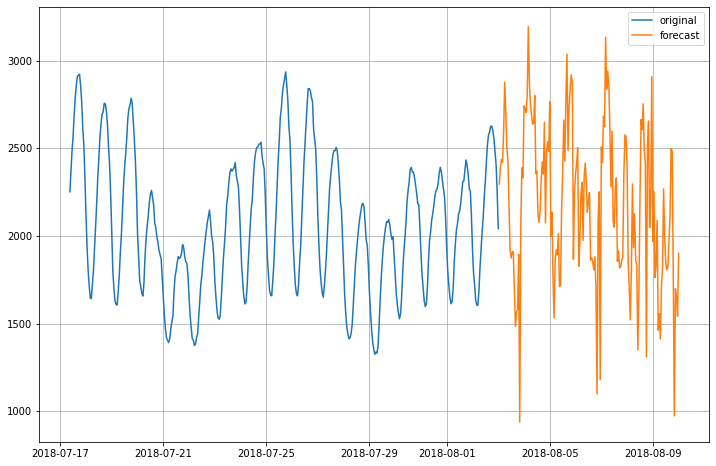

In [14]:
# Constructing the forecast dataframe
fc = d.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'MW': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'MW', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()
plt.show()    

In [15]:
fc

,Datetime,MW,type
0,2018-07-17 09:00:00,2251.000000,original
1,2018-07-17 10:00:00,2365.000000,original
2,2018-07-17 11:00:00,2486.000000,original
3,2018-07-17 12:00:00,2568.000000,original
4,2018-07-17 13:00:00,2692.000000,original
...,...,...,...
563,2018-08-09 20:00:00,973.163757,forecast
564,2018-08-09 21:00:00,1697.767212,forecast
565,2018-08-09 22:00:00,1653.228149,forecast
566,2018-08-09 23:00:00,1541.403931,forecast


# Decile (10 Quantile) based incentive model

In [29]:
# Logic - Highest 10 percentile demand will be penalized more as compared to lesser demands
# Any demand close to median will not be penalized
# Furthermore whenever demand is in in lower percentiles - incentives in the form of less unit (kwhr) price shall be
# offered to the consumer

In [39]:
# Appending forecasted next 168 hours of load data onto the original dataset
forecasted_data = fc[fc['type']=='forecast'][['Datetime', 'MW']]
new_dataset = d.append(forecasted_data)
# Fore incentive calculation taking trends only for last 1 year=8760 hours as every year electricty demand increases and hence average peak demand
# and off peak demand changes
new_dataset = new_dataset.tail(8760)

In [41]:
new_dataset = new_dataset.sort_values(by='MW')
new_dataset['Decile'], bin_edges = pd.qcut(new_dataset['MW'], q=10, labels=False, retbins=True)

In [42]:
# For decile in range (0,5) - Incentive
for i in range(0,5):
    new_dataset.loc[new_dataset['Decile']==i, 'Outcome'] = "Incentive of: "+str((5-i)*5)+"%"
    
# For Decile of 5 - No penalty and no incentive
new_dataset.loc[new_dataset['Decile']==5, 'Outcome'] = "No penalty and no incentive"

# For Decile in range(6,10) - Penalized for charging during surge time
for i in range(6,10):
    new_dataset.loc[new_dataset['Decile']==i, 'Outcome'] = "Penalty of: "+str((i-5)*5)+"%"

In [43]:
decile_bins = {}
for i in range(1, len(bin_edges)):
    decile_bins[(bin_edges[i-1], bin_edges[i])] = i-1

In [44]:
new_dataset.sort_values(by='Datetime')

,Datetime,MW,Decile,Outcome
112679,2017-08-10 00:00:00,1977.000000,4,Incentive of: 5%
112680,2017-08-10 01:00:00,1818.000000,2,Incentive of: 15%
112681,2017-08-10 02:00:00,1689.000000,1,Incentive of: 20%
112682,2017-08-10 03:00:00,1615.000000,1,Incentive of: 20%
112683,2017-08-10 04:00:00,1573.000000,1,Incentive of: 20%
...,...,...,...,...
563,2018-08-09 20:00:00,973.163757,0,Incentive of: 25%
564,2018-08-09 21:00:00,1697.767212,1,Incentive of: 20%
565,2018-08-09 22:00:00,1653.228149,1,Incentive of: 20%
566,2018-08-09 23:00:00,1541.403931,0,Incentive of: 25%
